In [ ]:
# default_exp analysis

# Analysis

> This contains fastai Learner extensions useful to perform prediction analysis.

In [ ]:
#export
from sklearn.model_selection import train_test_split
from tsai.imports import *
from tsai.utils import random_shuffle, shuffle_along_axis
from tsai.data.core import *
from tsai.inference import get_X_preds
from fastai.learner import * 

In [ ]:
#export
@patch
@delegates(subplots)
def show_probas(self:Learner, figsize=(6,6), ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if dl is None: dl = self.dls[ds_idx]
    if one_batch: dl = [dl.one_batch()]
    probas, targets = self.get_preds(dl=dl)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = np.random.choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    if isinstance(probas, torch.Tensor): probas = probas.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor): targets = targets.detach().cpu().numpy()
    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    # class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    class_probas = np.array([probas[i][t] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, [self.dls.vocab[x] for x in classes], fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()
    self.recorder = recorder

In [ ]:
#export
@patch
def plot_confusion_matrix(self:Learner, ds_idx=1, dl=None, thr=.5, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2, figsize=(6,6),
                          title_fontsize=16, fontsize=12, plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        if dl is None: dl = self.dls[ds_idx]
        assert dl.cat
        if dl.c == 2: # binary classification
            probas, preds = self.get_preds(dl=dl)
            y_pred = (probas[:, 1] > thr).numpy().astype(int)
            y_test = preds.numpy()
            if normalize: skm_normalize = 'true'
            else: skm_normalize = None
            cm = skm.confusion_matrix(y_test, y_pred, normalize=skm_normalize)
        else: 
            cm = ClassificationInterpretation.from_learner(self).confusion_matrix()

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(figsize=figsize, **kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        if self.dls.c == 2:
            plt.title(f"{title} (threshold: {thr})", fontsize=title_fontsize)
        else: 
            plt.title(title, fontsize=title_fontsize)
        tick_marks = np.arange(len(self.dls.vocab))
        plt.xticks(tick_marks, self.dls.vocab, rotation=90, fontsize=fontsize)
        plt.yticks(tick_marks, self.dls.vocab, rotation=0, fontsize=fontsize)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

        ax = fig.gca()
        ax.set_ylim(len(self.dls.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Actual', fontsize=fontsize)
        plt.xlabel('Predicted', fontsize=fontsize)
        plt.grid(False)

## Permutation importance

We've also introduced 2 methods to help you better understand how important certain features or certain steps are for your model. Both methods use permutation importance. 

⚠️**The permutation feature or step importance is defined as the decrease in a model score when a single feature or step value is randomly shuffled.**

So if you using accuracy (higher is better), the most important features or steps will be those with a *lower* value on the chart (as randomly shuffling them reduces performance). 

The opposite occurs for metrics like mean squared error (lower is better). In this case, the most important features or steps will be those with a *higher* value on the chart. 

There are 2 issues with step importance: 

* there may be many steps and the analysis could take very long
* steps will likely have a high autocorrelation

For those reasons, we've introduced an argument (n_steps) to group steps. In this way you'll be able to know which part of the time series is the most important. 

Feature importance has been adapted from https://www.kaggle.com/cdeotte/lstm-feature-importance by Chris Deotte (Kaggle GrandMaster).

In [ ]:
#export
@patch
def feature_importance(self:Learner, 
    X=None, # array-like object containing the time series. If None, all data in the validation set will be used.
    y=None, # array-like object containing the targets. If None, all targets in the validation set will be used.
    partial_n:(int, float)=None, # # (int) or % (float) of used to measure feature importance. If None, all data will be used.
    method:str='permutation', # Method used to invalidate feature. Use 'permutation' for shuffling or 'ablation' for setting values to np.nan.
    feature_names:list=None, # Optional list of feature names that will be displayed if available. Otherwise var_0, var_1, etc.
    sel_classes:(str, list)=None, # classes for which the analysis will be made
    key_metric_idx:int=0, # Optional position of the metric used. If None or no metric is available, the loss will be used.
    show_chart:bool=True, # Flag to indicate if a chart showing permutation feature importance will be plotted.
    figsize:tuple=(10, 5), # Size of the chart.
    title:str=None, # Optional string that will be used as the chart title. If None 'Permutation Feature Importance'.
    return_df:bool=True, # Flag to indicate if the dataframe with feature importance will be returned.
    save_df_path:Path=None, # Path where dataframe containing the permutation feature importance results will be saved.
    random_state:int=23, # Optional int that controls the shuffling applied to the data.
    verbose:bool=True, # Flag that controls verbosity.
    ):
    r"""Calculates feature importance as the drop in the model's validation loss or metric when a feature value is randomly shuffled"""
    
    assert method in ['permutation', 'ablation']

    # X, y
    if X is None:
        X = self.dls.valid.dataset.tls[0].items
        if hasattr(self.dls.valid.dataset.tls[0], '_splits'): X = X[self.dls.valid.dataset.tls[0]._splits]
    if y is None:
        y = self.dls.valid.dataset.tls[1].items
    if partial_n is not None:
        _, rand_idxs, *_ = train_test_split(np.arange(len(y)), y, test_size=partial_n, random_state=random_state, stratify=y)
        X = X.oindex[rand_idxs] if hasattr(X, 'oindex') else X[rand_idxs]
        y = y.oindex[rand_idxs] if hasattr(y, 'oindex') else y[rand_idxs]
    else: 
        X, y = X[:], y[:]
    if sel_classes is not None:
        filt = np.isin(y, listify(sel_classes))
        X, y = X[filt], y[filt]
    pv(f'X.shape: {X.shape}', verbose)
    pv(f'y.shape: {y.shape}', verbose)

    # Metrics
    metrics = [mn for mn in self.recorder.metric_names if mn not in ['epoch', 'train_loss', 'valid_loss', 'time']]
    if len(metrics) == 0 or key_metric_idx is None:
        metric_name = self.loss_func.__class__.__name__
        key_metric_idx = None
    else:
        metric_name = metrics[key_metric_idx]
        metric = self.recorder.metrics[key_metric_idx].func
    metric_name = metric_name.replace("train_", "").replace("valid_", "")
    pv(f'Selected metric: {metric_name}', verbose)

    # Selected vars & feature names
    sel_vars = not(isinstance(self.dls.sel_vars, slice) and self.dls.sel_vars == slice(None, None, None))
    if feature_names is None:
        feature_names = L([f"var_{i}" for i in range(X.shape[1])])
        if sel_vars:
            feature_names = feature_names[self.dls.sel_vars]
    else:
        feature_names = listify(feature_names)

    if sel_vars:
        assert len(feature_names) == len(self.dls.sel_vars)
    else:
        assert len(feature_names) == X.shape[1]
    sel_var_idxs = L(np.arange(X.shape[1]).tolist())
    if sel_vars:
        sel_var_idxs = sel_var_idxs[self.dls.sel_vars]
    assert len(feature_names) == len(sel_var_idxs)
    g = list(zip(np.arange(len(sel_var_idxs)+2), [0] + sel_var_idxs))
    
    # Loop
    COLS = ['BASELINE'] + list(feature_names)
    results = []
    pv(f'Computing feature importance ({method} method)...', verbose)
    try:
        if method == 'ablation':
            fs = self.dls.valid.after_batch.fs
            self.dls.valid.after_batch.fs = fs + [TSNan2Value()]
        for i,k in progress_bar(g):
            if i > 0:
                if k not in sel_var_idxs: continue
                save_feat = X[:, k].copy()
                if method == 'permutation':
                    # shuffle along samples & steps
                    X[:, k] = random_shuffle(X[:, k].flatten(), random_state=random_state).reshape(X[:, k].shape)
                elif method == 'ablation':
                    X[:, k] = np.nan
            if key_metric_idx is None:
                value = self.get_X_preds(X, y, with_loss=True)[-1].mean().item()
            else:
                output = self.get_X_preds(X, y)
                if self.dls.c == 2:
                    try: value = metric(output[1], output[0][:, 1]).item()
                    except: value = metric(output[0], output[1]).item()
                else:
                    value = metric(output[0], output[1]).item()
                del output
            pv(f"{k:3} feature: {COLS[i]:20} {metric_name}: {value:8.6f}", verbose)
            results.append([COLS[i], value])
            del value; gc.collect()
            if i > 0:
                X[:, k] = save_feat
                del save_feat; gc.collect()
        
        if method == 'ablation':
            self.dls.valid.after_batch.fs = fs

    except KeyboardInterrupt:
        if i > 0:
            X[:, k] = save_feat
            del save_feat; gc.collect()
        if method == 'ablation':
            self.dls.valid.after_batch.fs = fs

    # DataFrame
    df = pd.DataFrame(results, columns=["Feature", metric_name])
    df[f'{metric_name}_change'] = df[metric_name] - df.loc[0, metric_name]
    sign = np.sign(df[f'{metric_name}_change'].mean())
    if sign == 0: sign = 1
    df[f'{metric_name}_change'] = df[f'{metric_name}_change'] * sign

    # Display feature importance
    if show_chart:
        print()
        value_change = df.loc[1:, f'{metric_name}_change'].values
        pos_value_change = value_change.copy()
        neg_value_change = value_change.copy()
        pos_value_change[pos_value_change < 0] = 0
        neg_value_change[neg_value_change > 0] = 0
        plt.figure(figsize=(10, .5*len(value_change)))
        plt.barh(np.arange(len(value_change))[::-1], pos_value_change, color='lime', edgecolor='black')
        plt.barh(np.arange(len(value_change))[::-1], neg_value_change, color='red', edgecolor='black')
        plt.axvline(0, color='black')
        plt.yticks(np.arange(len(value_change))[::-1], df.loc[1:, "Feature"].values)
        if title is None: title = f'Feature Importance ({method} method)'
        plt.title(title, size=16)
        text = 'increase' if sign == 1 else 'decrease'
        plt.xlabel(f"{metric_name} {text} when feature is removed")
        plt.ylim((-1,len(value_change)))
        plt.show()

    # Save feature importance
    df = df.sort_values(metric_name, ascending=sign < 0).reset_index(drop=True)
    if save_df_path:
        if save_df_path.split('.')[-1] != 'csv': save_df_path = f'{save_df_path}.csv'
        df.to_csv(f'{save_df_path}', index=False)
        pv(f'Feature importance df saved to {save_df_path}', verbose)
    if return_df: 
        return df 

In [ ]:
#export
@patch
def step_importance(
    self:Learner, 
    X=None, # array-like object containing the time series. If None, all data in the validation set will be used.
    y=None, # array-like object containing the targets. If None, all targets in the validation set will be used.
    partial_n:(int, float)=None, # # (int) or % (float) of used to measure feature importance. If None, all data will be used.
    method:str='permutation', # Method used to invalidate feature. Use 'permutation' for shuffling or 'ablation' for setting values to np.nan.
    step_names:list=None, # Optional list of step names that will be displayed if available. Otherwise 0, 1, 2, etc.
    sel_classes:(str, list)=None, # classes for which the analysis will be made
    n_steps:int=1, # # of steps that will be analyzed at a time. Default is 1.
    key_metric_idx:int=0, # Optional position of the metric used. If None or no metric is available, the loss will be used.
    show_chart:bool=True, # Flag to indicate if a chart showing permutation feature importance will be plotted.
    figsize:tuple=(10, 5), # Size of the chart.
    title:str=None, # Optional string that will be used as the chart title. If None 'Permutation Feature Importance'.
    xlabel=None, # Optional string that will be used as the chart xlabel. If None 'steps'.
    return_df:bool=True, # Flag to indicate if the dataframe with feature importance will be returned.
    save_df_path:Path=None, # Path where dataframe containing the permutation feature importance results will be saved.
    random_state:int=23, # Optional int that controls the shuffling applied to the data.
    verbose:bool=True, # Flag that controls verbosity.
    ):
    r"""Calculates step importance as the drop in the model's validation loss or metric when a step/s value/s is/are randomly shuffled"""

    assert method in ['permutation', 'ablation']
    
    # X, y
    if X is None:
        X = self.dls.valid.dataset.tls[0].items
        if hasattr(self.dls.valid.dataset.tls[0], '_splits'): X = X[self.dls.valid.dataset.tls[0]._splits]
    if y is None:
        y = self.dls.valid.dataset.tls[1].items
    if partial_n is not None:
        _, rand_idxs, *_ = train_test_split(np.arange(len(y)), y, test_size=partial_n, random_state=random_state, stratify=y)
        X = X.oindex[rand_idxs] if hasattr(X, 'oindex') else X[rand_idxs]
        y = y.oindex[rand_idxs] if hasattr(y, 'oindex') else y[rand_idxs]
    else: 
        X, y = X[:], y[:]
    if sel_classes is not None:
        filt = np.isin(y, listify(sel_classes))
        X, y = X[filt], y[filt]
    pv(f'X.shape: {X.shape}', verbose)
    pv(f'y.shape: {y.shape}', verbose)
    

    # Metrics
    metrics = [mn for mn in self.recorder.metric_names if mn not in ['epoch', 'train_loss', 'valid_loss', 'time']]
    if len(metrics) == 0 or key_metric_idx is None:
        metric_name = self.loss_func.__class__.__name__
        key_metric_idx = None
    else:
        metric_name = metrics[key_metric_idx]
        metric = self.recorder.metrics[key_metric_idx].func
    metric_name = metric_name.replace("train_", "").replace("valid_", "")
    pv(f'Selected metric: {metric_name}', verbose)
    
    # Selected steps
    sel_step_idxs = L(np.arange(X.shape[-1]).tolist())[self.dls.sel_steps]
    if n_steps != 1:
        sel_step_idxs = [listify(sel_step_idxs[::-1][n:n+n_steps][::-1]) for n in range(0, len(sel_step_idxs), n_steps)][::-1]        
    g = list(zip(np.arange(len(sel_step_idxs)+2), [0] + sel_step_idxs))

    # Loop
    COLS = ['BASELINE'] + sel_step_idxs
    results = []
    _step_names = []
    pv('Computing step importance...', verbose)
    try:
        if method == 'ablation':
            fs = self.dls.valid.after_batch.fs
            self.dls.valid.after_batch.fs = fs + [TSNan2Value()]
        for i,k in progress_bar(g):
            if i > 0:
                if k not in sel_step_idxs: continue
                save_feat = X[..., k].copy()
                if method == 'permutation':
                    # shuffle along samples
                    X[..., k] = shuffle_along_axis(X[..., k], axis=0, random_state=random_state)
                elif method == 'ablation':
                    X[..., k] = np.nan
            if key_metric_idx is None:
                value = self.get_X_preds(X, y, with_loss=True)[-1].mean().item()
            else:
                output = self.get_X_preds(X, y)
                if self.dls.c == 2:
                    try: value = metric(output[1], output[0][:, 1]).item()
                    except: value = metric(output[0], output[1]).item()
                else:
                    value = metric(output[0], output[1]).item()
                del output
            
            # Step names
            if i == 0 or step_names is None:
                if i > 0 and n_steps != 1:
                    step_name = f"{str(COLS[i][0])} to {str(COLS[i][-1])}"
                else: step_name = str(COLS[i])
            else:
                step_name = step_names[i - 1]
            if i > 0: _step_names.append(step_name)
                
            pv(f"{i:3} step: {step_name:20} {metric_name}: {value:8.6f}", verbose)
            results.append([step_name, value])
            del value; gc.collect()
            if i > 0:
                X[..., k] = save_feat
                del save_feat; gc.collect()
        
        if method == 'ablation':
            self.dls.valid.after_batch.fs = fs

    except KeyboardInterrupt:
        if i > 0:
            X[..., k] = save_feat
            del save_feat; gc.collect()
        if method == 'ablation':
            self.dls.valid.after_batch.fs = fs

    # DataFrame
    df = pd.DataFrame(results, columns=["Step", metric_name])
    df[f'{metric_name}_change'] = df[metric_name] - df.loc[0, metric_name]
    sign = np.sign(df[f'{metric_name}_change'].mean())
    if sign == 0: sign = 1
    df[f'{metric_name}_change'] = df[f'{metric_name}_change'] * sign
    
    # Display step importance
    if show_chart:
        print()
        value_change = df.loc[1:, f'{metric_name}_change'].values
        pos_value_change = value_change.copy()
        neg_value_change = value_change.copy()
        pos_value_change[pos_value_change < 0] = 0
        neg_value_change[neg_value_change > 0] = 0
        plt.figure(figsize=(10, .5*len(value_change)))
        plt.bar(np.arange(len(value_change)), pos_value_change, color='lime', edgecolor='black')
        plt.bar(np.arange(len(value_change)), neg_value_change, color='red', edgecolor='black')
        plt.axhline(0, color='black')
        plt.xticks(np.arange(len(value_change)), _step_names, rotation=90)
        if title is None: title = f'Step Importance ({method} method)'
        plt.title(title, size=16)
        text = 'increase' if sign == 1 else 'decrease'
        if xlabel is None: xlabel = 'steps'
        plt.xlabel(xlabel)
        plt.ylabel(f"{metric_name} {text} when removed")
        plt.xlim((-1,len(value_change)))
        plt.show()

    # Save step importance
    df = df.sort_values(metric_name, ascending=sign < 0).reset_index(drop=True)
    if save_df_path:
        if save_df_path.split('.')[-1] != 'csv': save_df_path = f'{save_df_path}.csv'
        df.to_csv(f'{save_df_path}', index=False)
        pv(f'Step importance df saved to {save_df_path}', verbose)
    if return_df: 
        return df 

In [ ]:
from tsai.data.external import get_UCR_data
from tsai.data.preprocessing import TSRobustScale, TSStandardize
from tsai.learner import ts_learner
from tsai.models.FCNPlus import FCNPlus
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms  = [None, [TSClassification()]]
batch_tfms = TSRobustScale()
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y, splits=splits, sel_vars=[0, 3, 5, 8, 10], sel_steps=slice(-30, None), tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, FCNPlus, metrics=accuracy, train_metrics=True)
learn.fit_one_cycle(2)
# learn.plot_metrics()
# learn.show_probas()
# learn.plot_confusion_matrix()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.797391,0.195312,1.674329,0.211111,00:01
1,1.584900,0.632812,1.530492,0.283333,00:01


X.shape: (180, 24, 51)
y.shape: (180,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.283333


  0 feature: var_0                accuracy: 0.222222


  3 feature: var_3                accuracy: 0.172222


  5 feature: var_5                accuracy: 0.283333


  8 feature: var_8                accuracy: 0.288889


 10 feature: var_10               accuracy: 0.294444



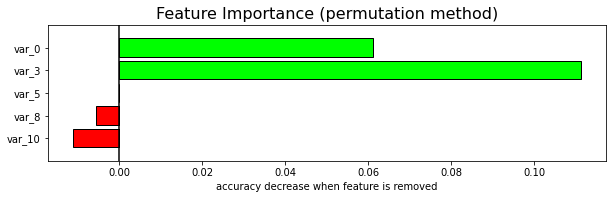

,Feature,accuracy,accuracy_change
0,var_3,0.172222,0.111111
1,var_0,0.222222,0.061111
2,BASELINE,0.283333,-0.000000
3,var_5,0.283333,-0.000000
4,var_8,0.288889,-0.005556
5,var_10,0.294444,-0.011111


In [ ]:
learn.feature_importance()

X.shape: (180, 24, 51)
y.shape: (180,)
Selected metric: accuracy
Computing step importance...


  0 step: BASELINE             accuracy: 0.288889


  1 step: 21 to 25             accuracy: 0.305556


  2 step: 26 to 30             accuracy: 0.255556


  3 step: 31 to 35             accuracy: 0.222222


  4 step: 36 to 40             accuracy: 0.244444


  5 step: 41 to 45             accuracy: 0.277778


  6 step: 46 to 50             accuracy: 0.294444



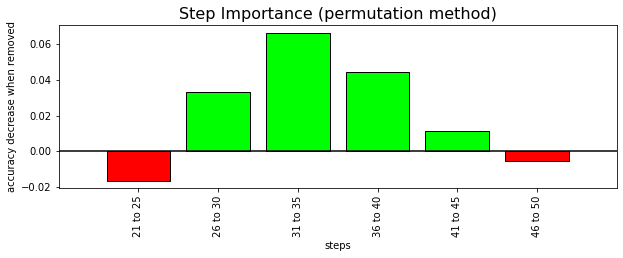

In [ ]:
learn.step_importance(n_steps=5);

You may pass an X and y if you want to analyze a particular group of samples: 

```bash
learn.feature_importance(X=X[splits[1]], y=y[splits[1]])
```

If you have a large validation dataset, you may also use the partial_n argument to select a fixed amount of samples (integer) or a percentage of the validation dataset (float):

```bash
learn.feature_importance(partial_n=.1)
```

```bash
learn.feature_importance(partial_n=100)
```

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);